In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="darkgrid")


In [0]:

df = pd.read_csv("GOLD.csv")
df.Date = pd.to_datetime(df['Date'])
df = df.set_index('Date')
print(df.index.dtype == "datetime64[ns]")
# print(df.columns)
print(df.info())

# for furthure exploration
df_droped = df.dropna()
df_to_fill = df.iloc[411 :, :]

# checking for empty column
empties = np.where(pd.isnull(df))
print('(starting_row, col) = ', empties[0][0], empties[1][0])



True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 512 entries, 2017-05-04 to 2019-05-03
Data columns (total 8 columns):
Price       512 non-null int64
Open        512 non-null int64
High        512 non-null int64
Low         512 non-null int64
Vol.        512 non-null object
Change %    512 non-null object
Pred        411 non-null float64
new         512 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 36.0+ KB
None
(starting_row, col) =  411 6


pred's score = 0.796205928915778
pred's coeff. =  [ 1.87728492  0.55565405 -2.43980328] bias  =  203.5283857599398

new's score = 0.9052828458304777
new's coeff. =  [-1.56905117  1.7921037  -0.22656291] bias =  102.77188726035811


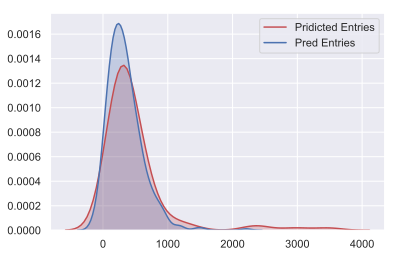

In [0]:
from sklearn.linear_model import LinearRegression
X = df_droped[['Open', 'High', 'Low']].values
pred = df_droped.Pred.values
new =  df_droped.new.values

#_______________________________linear Regression______________________
reg = LinearRegression().fit(X, pred)
print('pred\'s score =', reg.score(X, pred))
print('pred\'s coeff. = ', reg.coef_, 'bias  = ', reg.intercept_)

# pridicting the emty column and filling the rows of Pred
pred_to_fill = reg.predict(df_to_fill[['Open', 'High', 'Low']])
new_pridicted_pred = np.hstack((df_droped['Pred'].values, pred_to_fill))
df.Pred = new_pridicted_pred
print('')

reg2 = LinearRegression().fit(X, new)
print('new\'s score =', reg2.score(X, new))
print('new\'s coeff. = ', reg2.coef_, 'bias = ', reg2.intercept_)


ax = sns.kdeplot(pred_to_fill, label='Pridicted Entries', shade=True, color="r")
ax = sns.kdeplot(df_droped['Pred'], label='Pred Entries', shade=True, color="b")

In [0]:
#_______________________________Polynomial Regression__________________________
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                ('linear', LinearRegression())])

model = model.fit(X, pred)
print(model.score(X, pred))
print(model.named_steps['linear'].coef_)
print('')

model = model.fit(X, new)
print('new\'s score =', model.score(X, new))
print('new\'s coeff. = ', model.named_steps['linear'].coef_)
print('')

print(f"""Since the new column is giving the Score for Simple Linear Regression\
higher than the pred's column Score hence i think  new is linear function of\
OHL columns. Also the pred is polynomial function of OHL columns because it gives\
more +ve change in Score than the linear one while comparing to the new column""")


0.8159060375045508
[ 0.00000000e+00  8.31012462e-01  4.41739689e+00 -4.79572276e+00
  7.22421621e-04 -2.88457330e-03  1.50145869e-03  1.87985683e-03
 -1.03173471e-03 -1.94673740e-04]

new's score = 0.9147522370858088
new's coeff. =  [ 0.00000000e+00 -2.09388978e+00  3.74002532e+00 -1.41689019e+00
  3.62468554e-04 -1.47862677e-03  7.85041523e-04  9.75820068e-04
 -5.52469295e-04 -9.59030628e-05]

Since the new column is giving the Score for Simple Linear Regressionhigher than the pred's column Score hence i think  new is linear function ofOHL columns. Also the pred is polynomial function of OHL columns because it givesmore +ve change in Score than the linear one while comparing to the new column


In [0]:

# calling nifty as index
ndf = pd.read_csv('Nifty50.csv')
ndf.Date = pd.to_datetime(ndf['Date'])
ndf = ndf.set_index('Date')

# calling heromoto as stock
hdf = pd.read_csv('HEROMOTOCO.csv')
dhf = hdf[hdf["Series"] == "EQ"]
hdf.Date = pd.to_datetime(hdf['Date'])
hdf = hdf.set_index('Date')

# ______________________ Daily Beta ______________________________

index = ndf["Open"].where(hdf.index == ndf.index)
inedexReturn = (index.pct_change()*100).dropna().values.reshape(-1, 1)

stock = hdf["Open Price"].where(hdf.index == ndf.index)
stockReturn = (stock.pct_change()*100).dropna().values.reshape(-1, 1)

reg_for_beta_d = LinearRegression().fit(inedexReturn[len(inedexReturn)-60:].reshape(-1, 1), stockReturn[len(stockReturn)-60:].reshape(-1, 1))
print('3 Month\'s Daily Beta = ', reg_for_beta_d.coef_.tolist())


3 Month's Daily Beta =  [[0.8213591446879909]]


In [0]:
# Using covarience
daily_covMat = np.cov(inedexReturn[len(inedexReturn)-60:].reshape(1, -1), stockReturn[len(stockReturn)-60:].reshape(1, -1))
print('3 Month\'s Daily Beta = ', daily_covMat[0][1] / daily_covMat[0][0])



3 Month's Daily Beta =  0.8213591446879912


In [0]:
# _______________________ Monthly Beta ___________________________

index_m_last = index.loc[index.groupby(index.index.to_period('M')).apply(lambda x: x.index.max())]
inedexReturn_m_lats = (index_m_last.pct_change()*100).dropna().values.reshape(-1, 1)

stock_m_last = stock.loc[stock.groupby(stock.index.to_period('M')).apply(lambda x: x.index.max())]
stockReturn_m_last = (stock_m_last.pct_change()*100).dropna().values.reshape(-1, 1)

reg_for_beta_m = LinearRegression().fit(inedexReturn_m_lats.reshape(-1, 1), stockReturn_m_last.reshape(-1, 1))
print('Monthly Beta = ', reg_for_beta_m.coef_.tolist())

# Using covarianece
monthly_covMat = np.cov(inedexReturn_m_lats.reshape(1, -1), stockReturn_m_last.reshape(1, -1))
print('Monthly Beta = ', monthly_covMat[0][1] / monthly_covMat[0][0])


Monthly Beta =  [[0.5179140593697137]]
Monthly Beta =  0.5179140593697137


In [0]:
print("_"*20, "Write Up", "_"*20, end="\n")
print("""
\tIn both type of calculations (Monthly and daily) the Beta values are less than 1\
if the beta value happens to be negative then it is indication of that the stock as\
a whole loosing or in loss while index or market is in profit or gaining.
\n\tThe beta vaule of last Heromoto for daily last 3 months is ~0.82 which sugget that stock in less\
voletile than the market. while the monthly beta value (~0.52) suggest that the stock is even less voletile\
than the market or index. The daily beta value matches to the original beta value for Heromoto corp.\
with less than 0.02 error.
""")




____________________ Write Up ____________________

	In both type of calculations (Monthly and daily) the Beta values are less than 1if the beta value happens to be negative then it is indication of that the stock asa whole loosing or in loss while index or market is in profit or gaining.

	The beta vaule of last Heromoto for daily last 3 months is ~0.82 which sugget that stock in lessvoletile than the market. while the monthly beta value (~0.52) suggest that the stock is even less voletilethan the market or index. The daily beta value matches to the original beta value for Heromoto corp.with less than 0.02 error.

